### Advanced Topics in Theoretical Physics (2025)
# Assignment 1: Learning the classical Ising transition

## What this notebook is about:

The purpose of this notebook is to showcase how machine learning can used to make predicitions about the $2-$dimensional Ising model.

The _Wolff Algorithm_ is used to run the monte carlo simulation of the Ising model allowing for cluster spin flips.

This configurations of various systems at a fixed temperature $T$ are saved and split into a training and testing data set.

Some samples are visualized in black and white grids for various temperatures





###Contents of this notebook:

- Imports and algorithms
  - Imports
  - The Wolff Algorithm
  - Data generation for the Ising model

- Learning model
  - Train / Test splits
  - Building the network
  - Making a prediction
  - The loss function
  - The optimizer
  - The training loop

- Training and testing

- Challenge ideas

- Learning by confusion


In [1]:
#@title Imports
!pip install flax
from collections import deque
from functools import partial
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
plt.style.use('ggplot')
import numpy as np
from typing import Sequence

# To measure the time it takes to train a network
import time

# Everything we need from JAX
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.scipy.special import logsumexp # Computes the log of the sum of exponentials of input elements.
from jax.example_libraries import optimizers

# Flax module for deep learning models
import flax.linen as nn

# The key for our random number generator, we need this because JAX will distribute the calculation
key = random.PRNGKey(0)

%matplotlib inline

  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached humanize-4.13.0-py3-none-any.whl.metadata (7.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 12.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 MB 10.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.8/663.8 kB 9.1 MB/s eta 0:00:00
Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
Using cached absl_py-2.3.1-py3-none-any.whl (135 kB)
Using cached typing_extensions-4.15.0-py3-none-any.whl (44 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.1/563.1 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 9.5 MB/s eta 0:00:00ta 0:00:01
Using cached humanize-4.13.0-py3-none-any.whl (128 kB)
  Attempting uninstall: typing_extensions
    Found existing installation: typ

In [2]:
#@title Wolff Algorithm
class WolffMonteCarlo:
    """Wolff Monte Carlo simulator for Ising model."""

    def __init__(self, L, T, method=None):
        self._L = L
        self._T = T
        self._K = 2. / T

        # set up updater
        self._updater = partial(self.wolff_iterative, method=method)

        # set up initial state
        self._state = np.random.randint(0, 2, size=[L, L])

    @property
    def L(self):
        return self._L

    @property
    def T(self):
        return self._T

    @property
    def K(self):
        return self._K

    @property
    def state(self):
        return self._state

    def probability_add_bond(self, x1, y1, x2, y2, state):
        """The probability for adding a bond."""
        return 1. - np.exp(-self.K * (1. if state[x1, y1] == state[x2, y2] else 0.))

    def set_T(self, T):
        self._T = T
        self._K = 2. / T

    def wolff_iterative(self, state, method=None):
        """ Iterative Wolff algorithm based on deque. """

        # geometry
        L = self.L
        left = [L - 1] + list(range(L - 1))
        right = list(range(1, L)) + [0]
        # book-keeping containers
        sites_to_consider = deque()
        sites_to_flip = set()
        bonds_considered = set()

        # Initial queue of sites to consider, just consisting of a single site
        sites_to_consider.append((
            np.random.randint(0, L),
            np.random.randint(0, L)
        ))

        # As long as there are sites to consider
        while sites_to_consider:

            # Pick a new site to consider from the queue, either using
            # breadth first or depth first
            if method == "BFS":
                # queue
                x1, y1 = sites_to_consider.popleft()
            if method == "DFS":
                # stack
                x1, y1 = sites_to_consider.pop()

            # For each neighbor of this site
            for x2, y2 in zip([left[x1], right[x1], x1, x1],
                              [y1, y1, left[y1], right[y1]]):
                # Check if we have not already considered this pair
                if not (x1, y1, x2, y2) in bonds_considered:
                    # Add the pair so that we don't flip it twice
                    bonds_considered.add((x1, y1, x2, y2))
                    bonds_considered.add((x2, y2, x1, y1))

                    if np.random.rand() < self.probability_add_bond(x1, y1, x2, y2, state):
                        if method == "BFS":
                            sites_to_consider.append((x2, y2))
                        if method == "DFS":
                            sites_to_consider.append((x2, y2))

                        sites_to_flip.add((x1, y1))
                        sites_to_flip.add((x2, y2))
        return sites_to_flip

    def step(self):
        """Use Wolff and perform update."""

        # Get a list of sites to flip...
        to_flip = self._updater(self._state)

        # ...and flip them
        for (x, y) in to_flip:
            # 0 and 1, not -1 and 1
            self._state[x, y] = 1 - self._state[x, y]

        return to_flip

In [4]:
#@title Ising Data

def generate_Ising_configurations(L, numSamplesPerT, Ts, equilibrationSteps=100):
    ''' Generates training data for the 2D Ising model for a given set of temperatures

    Samples are generated using Wolff cluster updates.

    Parameters:

        * `L`: Linear size of the system
        * `numSamplesPerT`: Number of samples to generate per temperature
        * `Ts`: List of temperatures
        * `equilibrationSteps`: Number of equilibration steps

    Returns:

        * A dictionary with the sampled configurations for each temperature

    '''

    # Initialize a new simulator
    sim = WolffMonteCarlo(L=L, T=5, method="DFS")

    all_data = {}

    # Loop over a fixed set of temperatures
    for T in Ts:
        print("Generating samples for L = %d at T = %.3f"%(L,T))

        # Set temperature
        sim.set_T(T)

        # For storing all of the configurations
        res = []
        for s in range(numSamplesPerT + equilibrationSteps):

            # Keep flipping sites, until we flipped at least L^2 of them
            c = 0
            while c < 1:
                to_flip = sim.step()
                c = c + len(to_flip) / L / L

            # The first half of the flips are to equilibrate, the rest are
            # good samples
            if s >= equilibrationSteps:
                res.append(np.array(-1 + 2 * sim.state.reshape(-1)))


        all_data['%.3f'%(T)] = np.array(res)


    return all_data

# Generate training data

In [5]:
# The temperatures that we are going to generate samples at
Ts = np.arange(1.95, 0.04, -0.1) * 2.27

# For a few different system sizes, store the data in a dictionary with L as key
all_data = generate_Ising_configurations(10, 1000, Ts)

Generating samples for L = 10 at T = 4.426
Generating samples for L = 10 at T = 4.199
Generating samples for L = 10 at T = 3.972
Generating samples for L = 10 at T = 3.745
Generating samples for L = 10 at T = 3.518
Generating samples for L = 10 at T = 3.291
Generating samples for L = 10 at T = 3.064
Generating samples for L = 10 at T = 2.837
Generating samples for L = 10 at T = 2.610
Generating samples for L = 10 at T = 2.383
Generating samples for L = 10 at T = 2.156
Generating samples for L = 10 at T = 1.929
Generating samples for L = 10 at T = 1.702
Generating samples for L = 10 at T = 1.475
Generating samples for L = 10 at T = 1.248
Generating samples for L = 10 at T = 1.021
Generating samples for L = 10 at T = 0.794
Generating samples for L = 10 at T = 0.567
Generating samples for L = 10 at T = 0.340
Generating samples for L = 10 at T = 0.113


## Split the training data

In [6]:
def get_training_data(all_data, Ts, Tc=2.7, train_fraction=0.8):
    # Lists to store the raw data
    raw_T = []
    raw_x = []
    raw_y = []

    for T in Ts:
        raw_x.append(all_data['%.3f'%(T)])
        n = len(all_data['%.3f'%(T)])
        label = [1,0] if T < Tc else [0,1]
        raw_y.append(np.array([label] * n))
        raw_T.append(np.array([T]*n))

    raw_T = np.concatenate(raw_T)
    raw_x = np.concatenate(raw_x, axis=0)
    raw_y = np.concatenate(raw_y, axis=0)

    # Shuffle
    indices = np.random.permutation(len(raw_x))
    all_T = raw_T[indices]
    all_x = raw_x[indices]
    all_y = raw_y[indices]

    # Split into train and test sets
    train_split = int(train_fraction * len(all_x))
    train_T = jnp.array(all_T[:train_split])
    train_x = jnp.array(all_x[:train_split])
    train_y = jnp.array(all_y[:train_split])
    test_T = jnp.array(all_T[train_split:])
    test_x = jnp.array(all_x[train_split:])
    test_y = jnp.array(all_y[train_split:])

    return [raw_T, raw_x, raw_y], [train_T, train_x, train_y], [test_T, test_x, test_y]

### Visualize some data samples

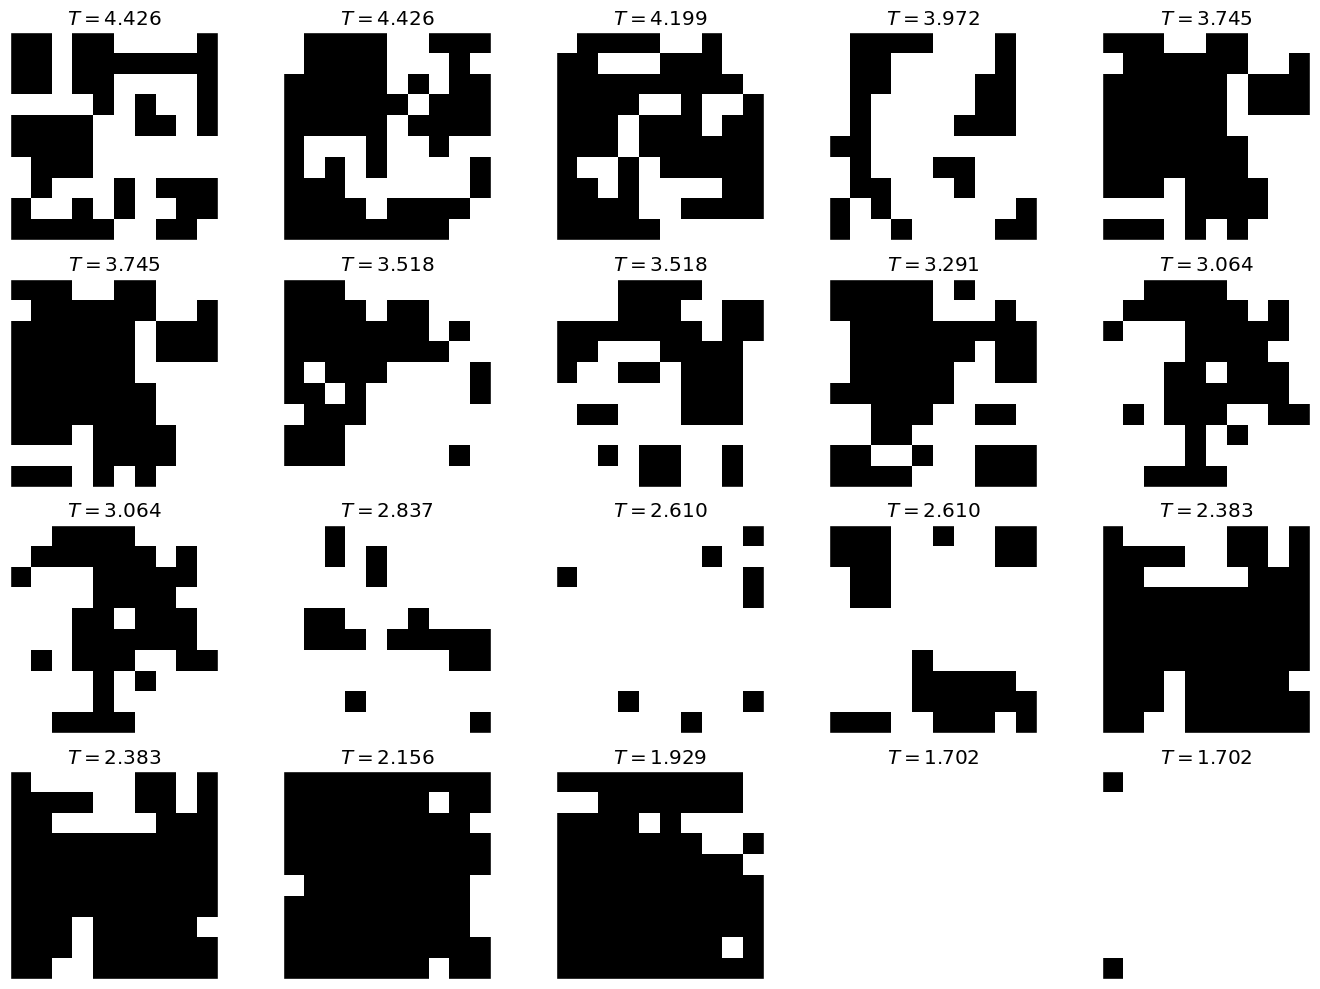

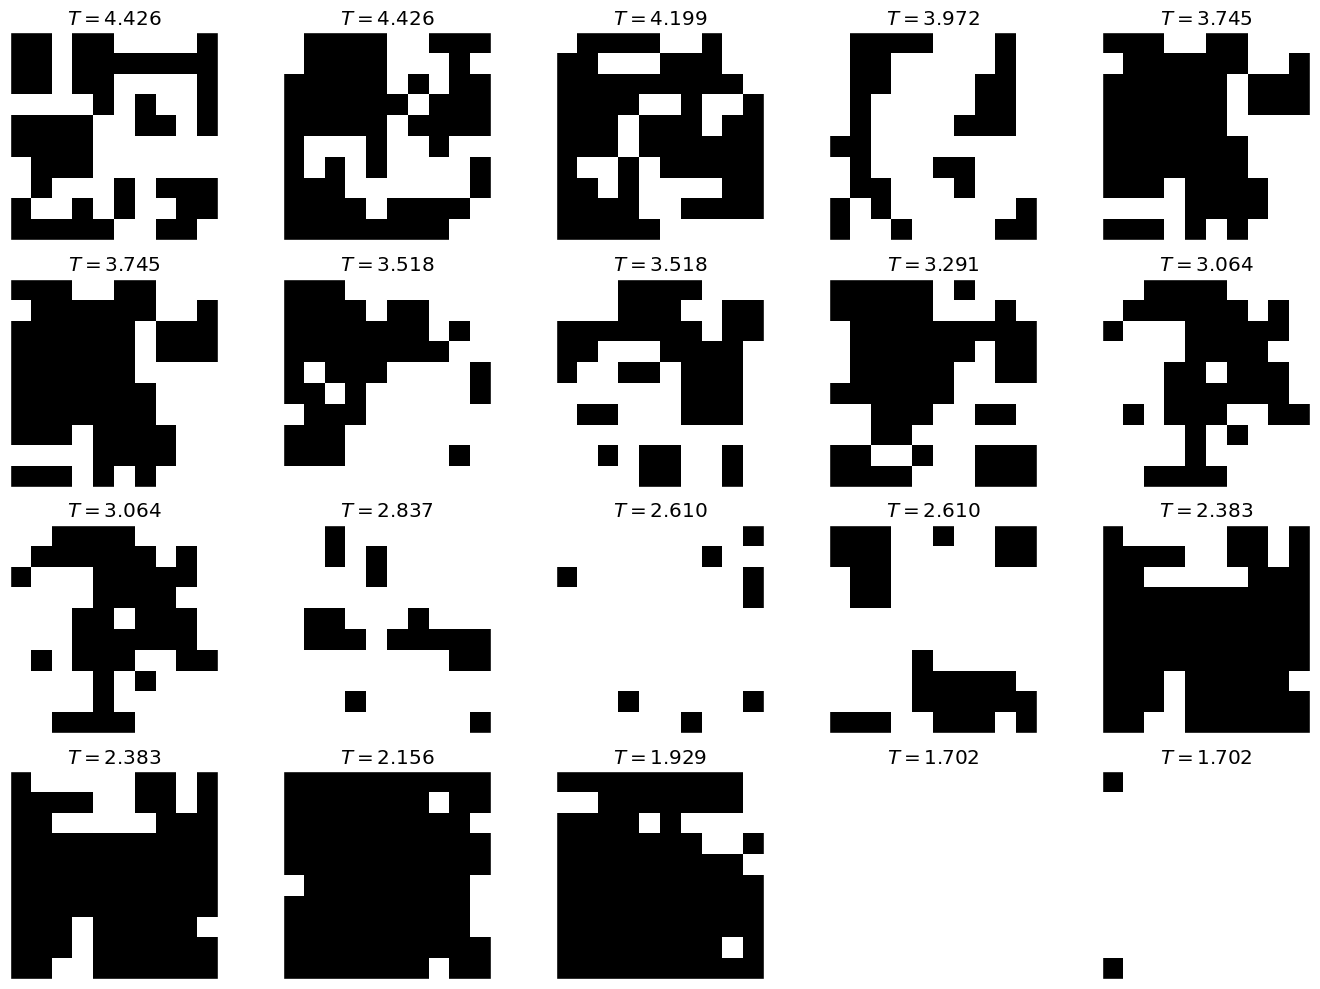

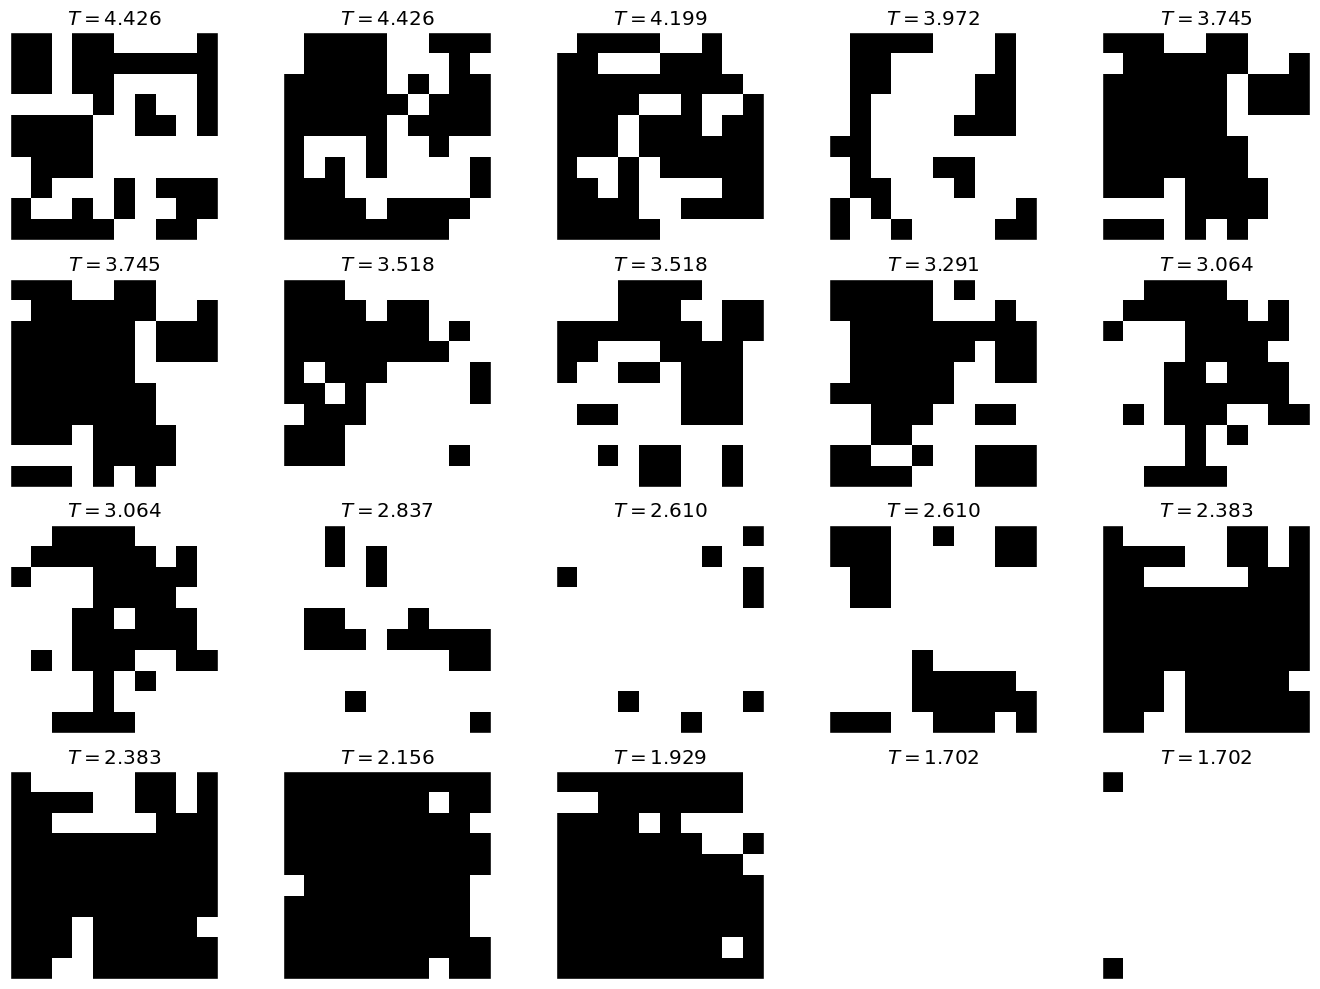

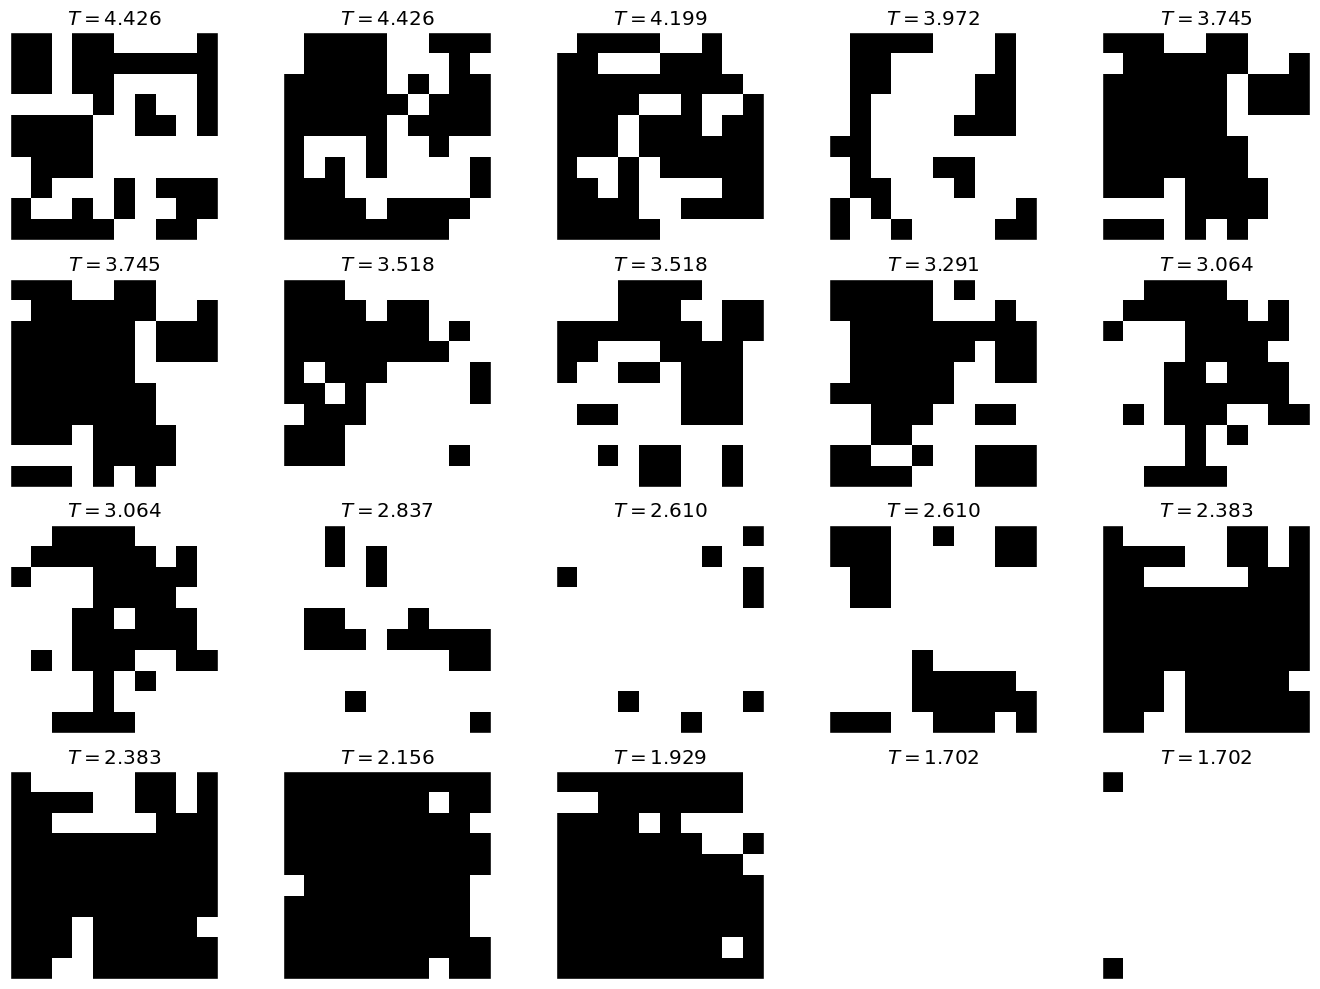

In [10]:
# Make 2-d plots of black and white pixelated visualization of the spins
[raw_T, raw_x, raw_y], [train_T, train_x, train_y], [test_T, test_x, test_y] = get_training_data(all_data,Ts)

fig, ax = plt.subplots(4,5, figsize=(14,10))
for i in range(4):
    for j in range(5):
        ax[i,j].matshow(np.reshape(raw_x[(4*i + j)*800], (10,10)), cmap='Greys')
        ax[i,j].set_title("$T = %.3f$"%raw_T[(4*i + j)*800])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
fig.tight_layout()

plt.show()

## Make a Feedforward network

In [11]:
class MyNet(nn.Module):
    layers: Sequence[int] # A tuple that contains the widths of all layers follwing the input layer

    @nn.compact
    def __call__(self, x):

        a = x.ravel() # flatten the input

        # Evaluate network layer by layer
        for width in self.layers[:-1]:
            # Apply a the Dense layer with given width followed by the non-linearity
            a = nn.relu(nn.Dense(width)(a))

        a = nn.Dense(self.layers[-1])(a)

        # Return activations of the output layer
        return a - logsumexp(a)

# Initialize a new network (or rather its parameters)
layer_sizes = [100, 64, 32, 2]
net = MyNet(layers=layer_sizes)

### Define the forward prediction of our network

In [12]:
# Make a batched `predict` function
predict = jax.vmap(lambda p, x: net.apply(p,x), in_axes=(None, 0), out_axes=0)

## The loss function

In [13]:
def loss(params, images, targets):
    """ Compute the loss for a batch of data """
    preds = predict(params, images)
    return -jnp.mean(preds * targets)

## The optimizer

In [14]:
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)

@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

## Training loop

In [15]:
def accuracy(params, images, targets):
    """Define the accuracy as the average number of correct predictions."""
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(predict(params, images), axis=1)
    return jnp.mean(predicted_class == target_class)

def train(train_x, train_y, test_x, test_y, num_epochs, batch_size, opt_state):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy(params, train_x, train_y)
    test_acc = accuracy(params, test_x, test_y)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Divide into batches
    num_batches = len(train_x) // batch_size

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()

        # Shuffle data
        indices = np.random.permutation(len(train_x))
        batch_indices = jnp.split(indices[:num_batches*batch_size], batch_size)

        for b in range(len(batch_indices)):
            x = train_x[batch_indices[b]]
            y = train_y[batch_indices[b]]

            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        train_acc = accuracy(params, train_x, train_y)
        test_acc = accuracy(params, test_x, test_y)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | Time: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))


    return train_loss, log_acc_train, log_acc_test, params

# Blanking: train model in known limits, then use it to predict the rest

In [16]:
# Pick only the Ts at the beginning and at the end, and construct a dataset
train_Ts = list(Ts[:4]) + list(Ts[-4:])
[raw_T, raw_x, raw_y], [train_T, train_x, train_y], [test_T, test_x, test_y] = get_training_data(all_data, train_Ts)

# Initialize a new network (or rather its parameters)
params = MyNet(layers=layer_sizes).init(key, train_x[0])

# Initialize the optimizer
opt_state = opt_init(params)

Epoch 1 | Time: 0.02 | Train A: 1.000 | Test A: 1.000
Epoch 2 | Time: 0.02 | Train A: 1.000 | Test A: 1.000
Epoch 3 | Time: 0.02 | Train A: 1.000 | Test A: 1.000
Epoch 4 | Time: 0.02 | Train A: 1.000 | Test A: 1.000
Epoch 5 | Time: 0.01 | Train A: 1.000 | Test A: 1.000
Epoch 6 | Time: 0.01 | Train A: 1.000 | Test A: 1.000
Epoch 7 | Time: 0.02 | Train A: 1.000 | Test A: 1.000
Epoch 8 | Time: 0.02 | Train A: 1.000 | Test A: 1.000
Epoch 9 | Time: 0.02 | Train A: 1.000 | Test A: 1.000
Epoch 10 | Time: 0.01 | Train A: 1.000 | Test A: 1.000
Epoch 11 | Time: 0.01 | Train A: 1.000 | Test A: 1.000
Epoch 12 | Time: 0.01 | Train A: 1.000 | Test A: 1.000
Epoch 13 | Time: 0.01 | Train A: 1.000 | Test A: 1.000
Epoch 14 | Time: 0.02 | Train A: 1.000 | Test A: 1.000
Epoch 15 | Time: 0.02 | Train A: 1.000 | Test A: 1.000
Epoch 16 | Time: 0.02 | Train A: 1.000 | Test A: 1.000
Epoch 17 | Time: 0.02 | Train A: 1.000 | Test A: 1.000
Epoch 18 | Time: 0.02 | Train A: 1.000 | Test A: 1.000
Epoch 19 | Time: 0.

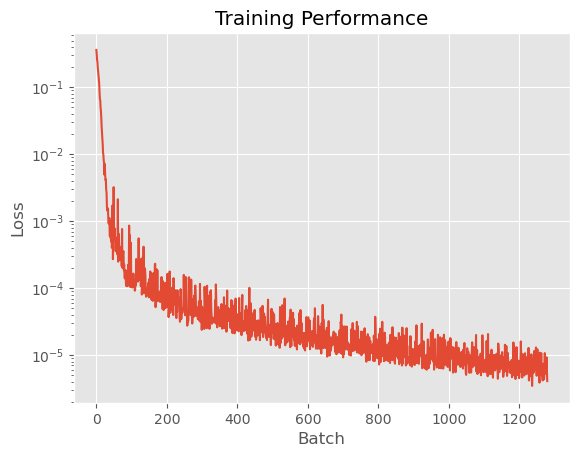

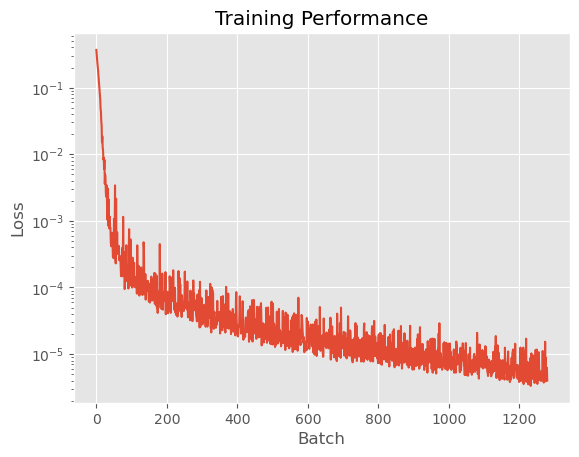

In [18]:
# Train the network
train_loss, train_log, test_log, params = train(train_x, train_y, test_x, test_y, 40, 32, opt_state)

fig, ax = plt.subplots(dpi=100)
ax.plot(train_loss)
ax.set_xlabel("Batch")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_title("Training Performance")

plt.show()

## Predict for all Ts

In [19]:
# For every temperature, get the averaged prediction
predictions = []
for T in Ts:
    x = all_data['%.3f'%T]#['x']
    p = jnp.exp( predict(params, x) )  # Exponentiate it to go back to the [0,1] range for nicer plotting
    p = jnp.mean( p, axis=0 )
    predictions.append(p)

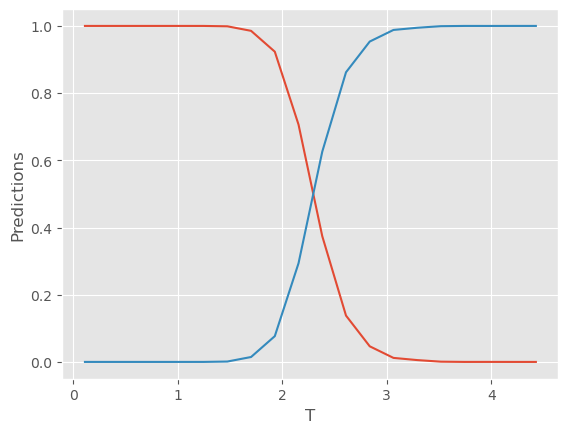

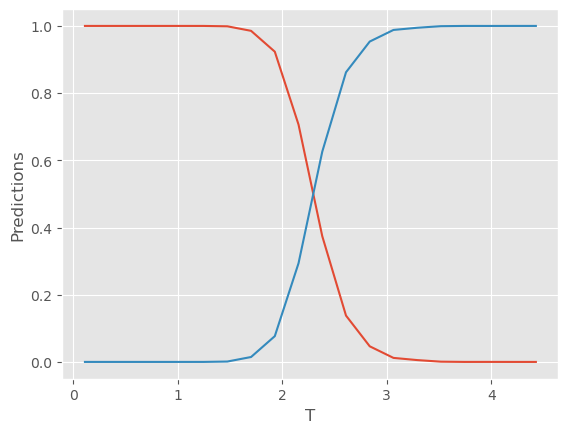

In [21]:
fig, ax = plt.subplots(dpi=100)
ax.plot( Ts, predictions )
ax.set_xlabel("T")
ax.set_ylabel("Predictions")

plt.show()

# Exercise 1:

In [ ]:
# Briefly explain what the "predictions" graph represents.
# Fit a sigmoid to the outputs to extract the crossing point (=Tc)
# See how the crossing point depends on:
    # The (width of the) regions in which you train
    # The network architecture
    # Size of the data (instead of 10x10 snapshots)

# Convert to use a Flax model
# Convert to use PyTorch or Keras / TensorFlow

# Learning by confusion

This is a  method where a neural network is trained on deliberately mislabeled data. By analyzing how well the NN performs under these "confused" labels, one can identify the true phase transition point.

Input data:

- For classical systems, raw configurations (e.g., from Monte Carlo simulations) are used.

Procedure:

- Propose a trial critical point c'.

- Label all data on one side of c' as phase 0, and the other as phase 1.

- Train a NN and evaluate its performance P(c').

- Repeat for many c' values.

Signature of Transition:

- The performance curve P(c′)P forms a universal W-shape, with the middle peak indicating the true critical point cc.

In [24]:
def train_with_guess(Ts, Tc_guess):
    [raw_T, raw_x, raw_y], [train_T, train_x, train_y], [test_T, test_x, test_y] = get_training_data(all_data, Ts, Tc=Tc_guess, train_fraction=0.9)

    # Initialize a new network (or rather its parameters)
    params = MyNet(layers=layer_sizes).init(key, train_x[0])

    # Initialize the optimizer
    opt_state = opt_init(params)

    train_loss, train_log, test_log, params = train(train_x, train_y, test_x, test_y, 5, 16, opt_state)

    return train_log

In [25]:
W_over_time = {}
for guess in np.linspace(Ts[0], Ts[-1], 10):
    print("Training at guess %.3f"%guess)
    accuracy_vs_epoch = train_with_guess(Ts, guess)
    W_over_time[guess] = accuracy_vs_epoch
    print("\t Final accuracy: %.3f"%accuracy_vs_epoch[-1])

Training at guess 4.426
Epoch 1 | Time: 0.36 | Train A: 0.949 | Test A: 0.958
Epoch 2 | Time: 0.02 | Train A: 0.949 | Test A: 0.958
Epoch 3 | Time: 0.02 | Train A: 0.949 | Test A: 0.958
Epoch 4 | Time: 0.02 | Train A: 0.949 | Test A: 0.958
Epoch 5 | Time: 0.02 | Train A: 0.949 | Test A: 0.958
	 Final accuracy: 0.949
Training at guess 3.947
Epoch 1 | Time: 0.02 | Train A: 0.851 | Test A: 0.845
Epoch 2 | Time: 0.02 | Train A: 0.853 | Test A: 0.839
Epoch 3 | Time: 0.02 | Train A: 0.859 | Test A: 0.841
Epoch 4 | Time: 0.02 | Train A: 0.865 | Test A: 0.846
Epoch 5 | Time: 0.04 | Train A: 0.870 | Test A: 0.849
	 Final accuracy: 0.870
Training at guess 3.468
Epoch 1 | Time: 0.02 | Train A: 0.864 | Test A: 0.857
Epoch 2 | Time: 0.02 | Train A: 0.872 | Test A: 0.863
Epoch 3 | Time: 0.02 | Train A: 0.875 | Test A: 0.867
Epoch 4 | Time: 0.02 | Train A: 0.879 | Test A: 0.860
Epoch 5 | Time: 0.02 | Train A: 0.881 | Test A: 0.857
	 Final accuracy: 0.881
Training at guess 2.989
Epoch 1 | Time: 0.03 |

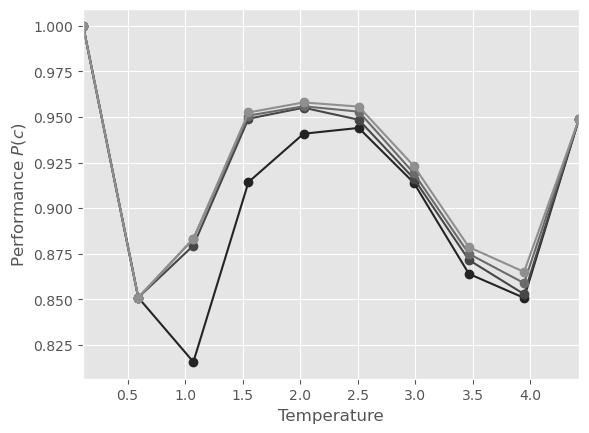

In [26]:
guess_Ts = np.linspace(Ts[0], Ts[-1], 10)

for i in range(1,5):
    curve = [W_over_time[guess][i] for guess in guess_Ts]
    color = np.array([0.7, 0.7, 0.7])*i/5
    plt.plot(guess_Ts, curve, '-o', c=color )
    plt.xlim((Ts[-1], Ts[0]))
    plt.xlabel('Temperature')
    plt.ylabel('Performance $P(c)$')

plt.show()

## Exercise 2:

In [ ]:
# Play with the hyperparameters to build intuition, see if you can get a clear W shape
# Increase the temperature resolution
# Increase the number of epochs trained for, you should be able to see the W become more flat -> why is this?